In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import os
import sys; sys.path.insert(1, './classes/')
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import time

from elastostatic import *
from tools import *

tol = 1e-10
components = ['V', 'N', 'E']
nature = ['Re', 'Im']

--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.39 seconds]


In [44]:
np.degrees(np.arctan2( -0,-1))

180.0

In [50]:
x = -124
t = 564
a = (x if x > 10 else t)

In [51]:
a

564

In [52]:
def open_simple_grid(filename = '../stations/LandOceanGrid_x_2.0_y_2.0_bounds_-89_89_0_360.txt'):
    with open(filename, 'r') as file:
        return np.array([line.split() for line in file.readlines()], dtype=float)
    
def polar2compl(magn, phase):
    r = magn*np.cos(phase)
    i = magn*np.sin(phase)
    return r, i

def compl2polar(real, imag):
    absv  = np.linalg.norm([real, imag])
    phase = np.arctan2(imag, real)
    phase = phase if imag > 0 else 2*np.pi + phase
    return absv, phase

In [53]:
regular_grid = open_simple_grid()

In [54]:
indices = [str(ind) for ind in regular_grid[:,2].astype(int)]
side_points = get_gps_stations(indeces = indices, latitudes = regular_grid[:,0], longitudes = regular_grid[:,1],)

In [55]:
receivers = {f'{station.name}':{'SidePoint': station} for station in side_points}

In [56]:
with open("../stations/cn_OceanOnly_GOT410c-M2_cm_convgf_GOT410c_global_PREM.txt") as file:
    data = np.array([line.split() for line in file.readlines()])
header = data[0]
regular_grid = data[1:].astype(float)

indices     = [str(ind) for ind in regular_grid[:,0].astype(int)]
east_ri     = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,3], regular_grid[:,4])])/1000.
north_ri    = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,5], regular_grid[:,6])])/1000.
vert_ri     = np.array([polar2compl(magn, np.radians(phase)) for magn, phase in zip(regular_grid[:,7], regular_grid[:,8])])/1000.
side_points = get_gps_stations(indeces = indices, latitudes = regular_grid[:,1], longitudes = regular_grid[:,2],)

In [57]:
for i, ind in enumerate(regular_grid[:,0].astype(int)):
    receivers[f'XX.{ind}.']['lat'] = regular_grid[i,1]
    receivers[f'XX.{ind}.']['lon'] = regular_grid[i,2]

In [58]:
receivers = {f'{station.name}':{'SidePoint': station, 
                                'lat': lat, 'lon': lon,   
                                'E-Re-LD': e_re, 'E-Im-LD': e_im, 
                                'N-Re-LD': n_re, 'N-Im-LD': n_im, 
                                'V-Re-LD': v_re, 'V-Im-LD': v_im,
                                'E-Ab-LD': e_ab, 'E-Ph-LD': e_ph,
                                'N-Ab-LD': n_ab, 'N-Ph-LD': n_ph,
                                'V-Ab-LD': v_ab, 'V-Ph-LD': v_ph} 
             for station,
                 lat, lon,
                 e_re, e_im, 
                 n_re, n_im, 
                 v_re, v_im,
                 e_ab, e_ph,
                 n_ab, n_ph,
                 v_ab, v_ph
             in 
             zip(side_points,
                 regular_grid[:,1], regular_grid[:,2],
                 east_ri [:,0], east_ri [:,1], 
                 north_ri[:,0], north_ri[:,1], 
                 vert_ri [:,0], vert_ri [:,1],
                 regular_grid[:,3], regular_grid[:,4],
                 regular_grid[:,5], regular_grid[:,6],
                 regular_grid[:,7], regular_grid[:,8])
            }

In [59]:
for i, ind in enumerate(indices):
    for j, comp in enumerate(components):
        ab_ld, ph_ld = compl2polar(receivers[f'XX.{ind}.'][f'{comp}-Re-LD'], receivers[f'XX.{ind}.'][f'{comp}-Im-LD'])
        receivers[f'XX.{ind}.'][f'{comp}-Ph-LD-test'] = np.degrees(ph_ld)

/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if __name__ == "__main__":


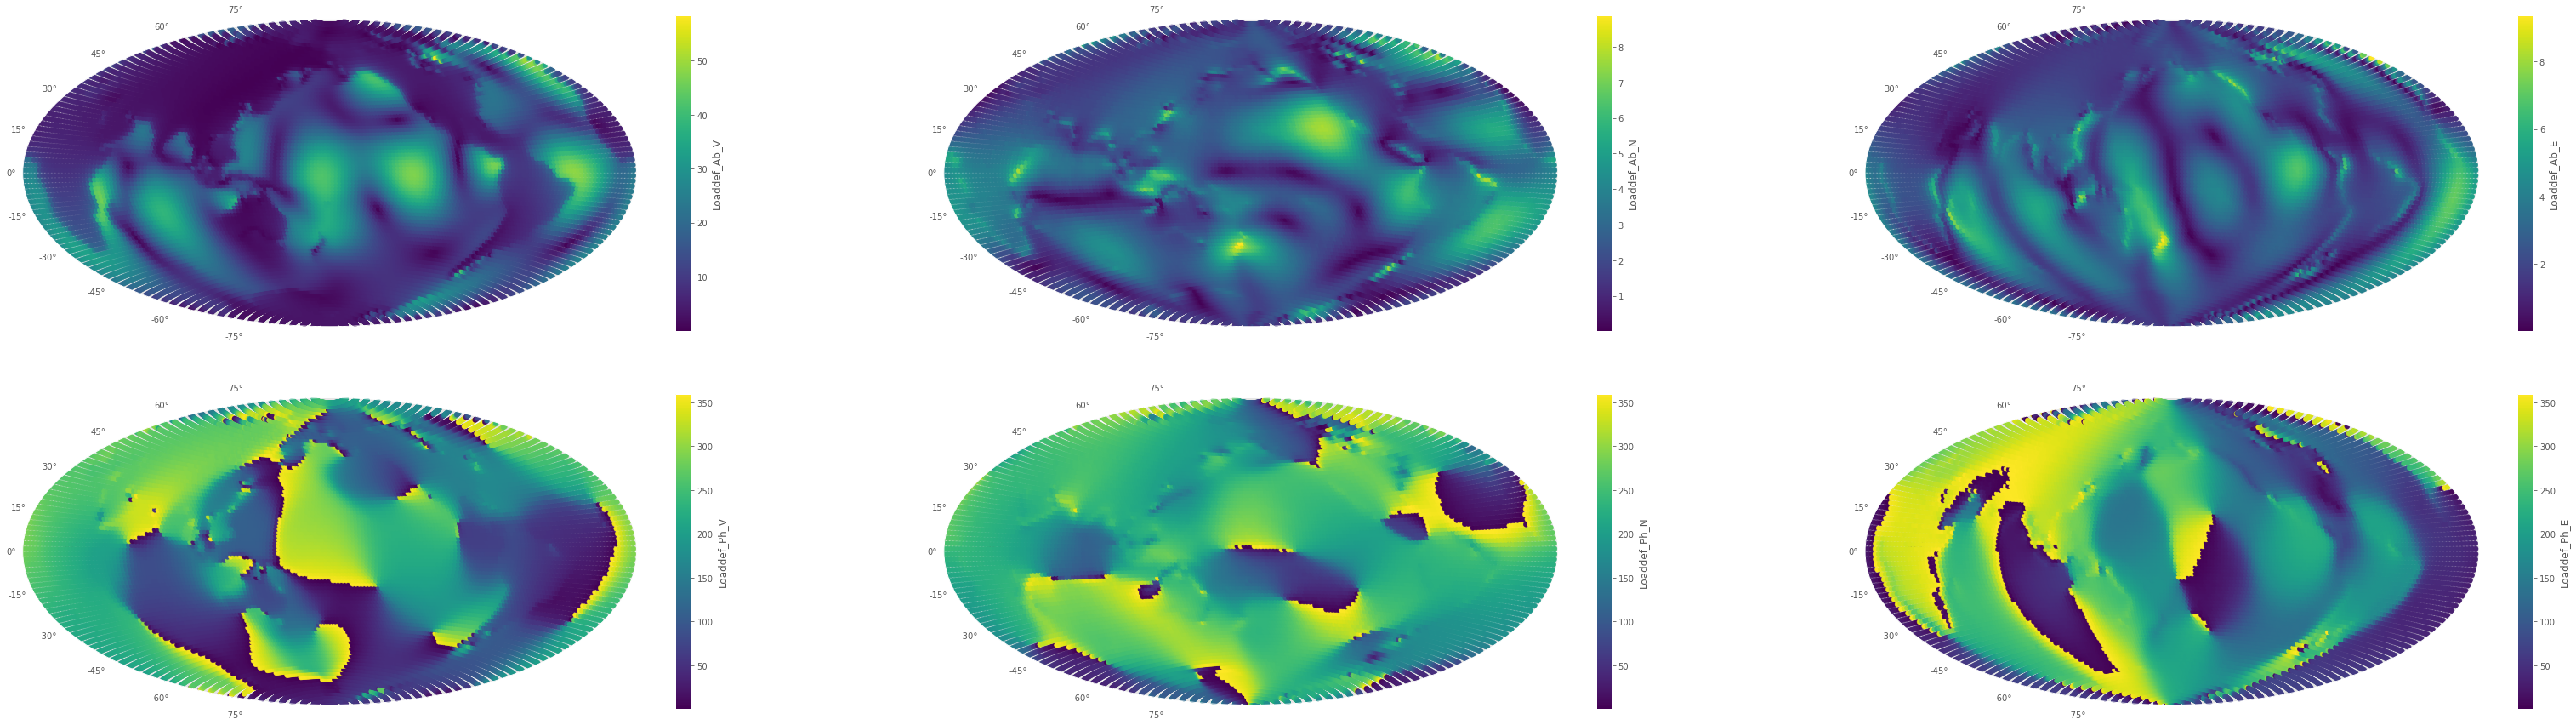

In [60]:
fig, ax = plt.subplots(2,3,figsize=(55,15), subplot_kw={"projection":'aitoff'})

lat = [receivers[f'XX.{ind}.']['lat'] for ind in indices]
lon = [receivers[f'XX.{ind}.']['lon']-180 for ind in indices]
for i, comp in enumerate(components):
    for j, nat in enumerate(['Ab', 'Ph']):
        field_to_plot = [receivers[f'XX.{ind}.'][f'{comp}-{nat}-LD'] for ind in indices]
        im = ax[j, i].scatter( np.radians(lon), np.radians(lat), c=field_to_plot)
        plt.colorbar(im, ax=ax[j, i], label=f'Loaddef_{nat}_{comp}')

/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


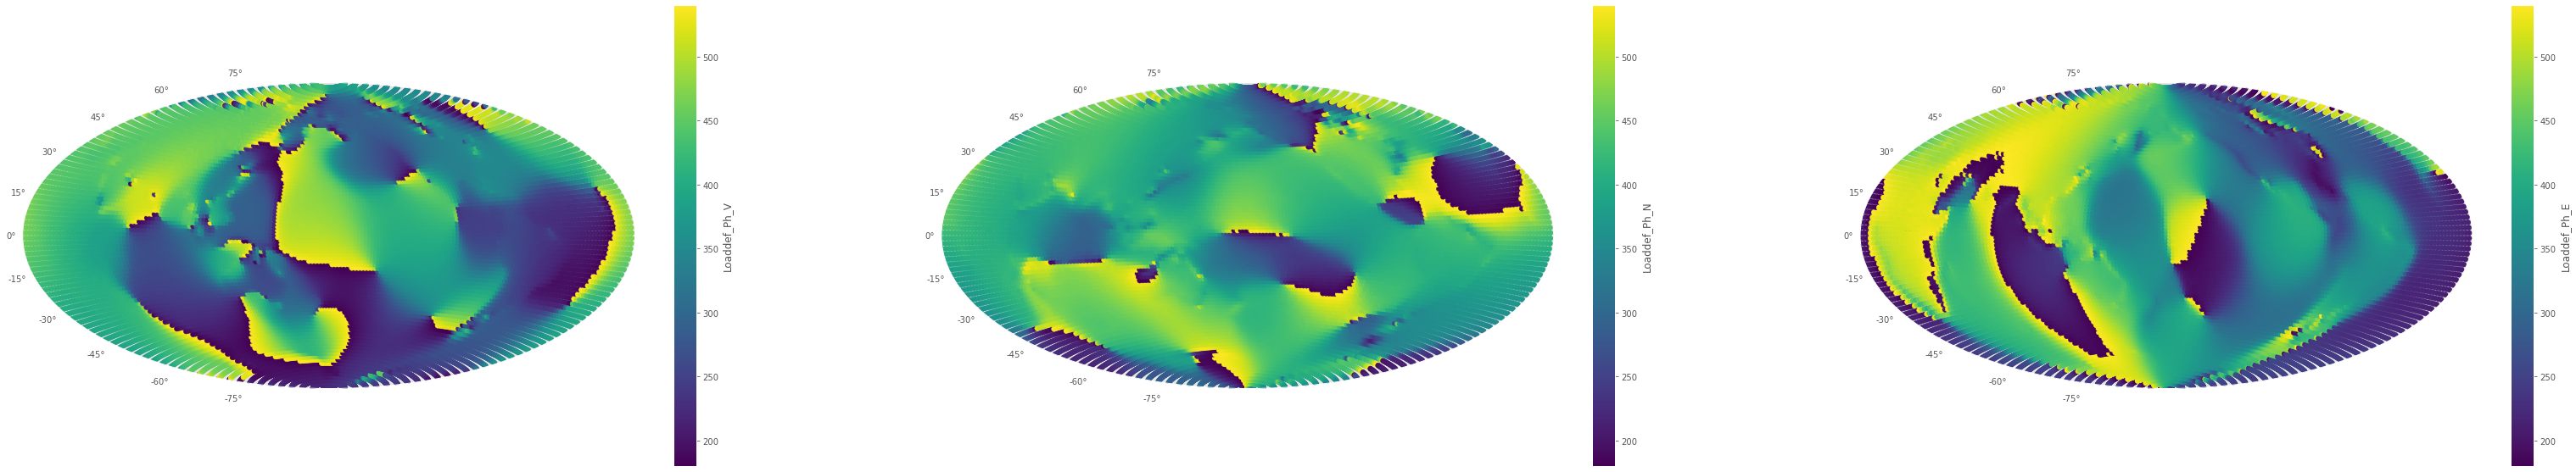

In [61]:
fig, ax = plt.subplots(1,3, figsize=(55,10), subplot_kw={"projection":'aitoff'})

lat = [receivers[f'XX.{ind}.']['lat'] for ind in indices]
lon = [receivers[f'XX.{ind}.']['lon']-180 for ind in indices]
for i, comp in enumerate(components):
        field_to_plot = [receivers[f'XX.{ind}.'][f'{comp}-Ph-LD-test'] + 180 for ind in indices]
        im = ax[i].scatter( np.radians(lon), np.radians(lat), c=field_to_plot)
        plt.colorbar(im, ax=ax[i], label=f'Loaddef_{nat}_{comp}')

In [24]:
ind = np.where(np.array([(receivers[f'XX.{ind}.'][f'{comp}-Ph-LD-test']) - receivers[f'XX.{ind}.'][f'{comp}-{nat}-LD'] for ind in indices]) < -300)

In [31]:
np.array([receivers[f'XX.{ind}.'][f'{comp}-Ph-LD-test'] for ind in indices])[ind[0]]

array([  -1.67040844,   -4.60658014,   -7.25216189, ..., -169.60611834,
       -172.9040579 , -175.47955963])

In [28]:
ind[0]

array([   40,    41,    42, ..., 15942, 15943, 15944])